# World Cup Penalty Shootout Analysis

Data source: https://www.kaggle.com/datasets/pablollanderos33/world-cup-penalty-shootouts

In this exploratory analysis, I take a look at Penalty shootout data from 34 matches, the most recent during the 2022 World Cup in Qatar. I take a look at the statistics from both the Penalty taker and the Goalkeeper perspective.

First let's look at the data...

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

In [33]:
df = pd.read_csv('WorldCupShootouts.csv')

In [37]:
df.head()

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination
0,1,FRA,7.0,R,R,1.0,1.0,1,0.0
1,1,GER,9.0,R,C,1.0,1.0,2,0.0
2,1,FRA,6.0,R,L,1.0,1.0,3,0.0
3,1,GER,2.0,R,C,1.0,1.0,4,0.0
4,1,FRA,9.0,R,L,1.0,1.0,5,0.0


For each Penalty taken, the following data points are available:
- Game_id: An integer representing the match in question, in chronological order
- Team: 3-character abbreviation representing the team taking the penalty
- Zone: The area of the goal towards which the penalty was directed. (There are 9 zones in total, see below)
- Foot: The foot (left or right) used to take the penalty
- Keeper: The direction (left, centre or right) in which the keeper attempted a save
- OnTarget: Was the penalty on target (1) or off-target (0)
- Goal: Was the penalty scored (1) or not (0)
- Penalty_Number: The order of the penalty within the match
- Elimination: Could this penalty be the last one? I.e. did it, or could it, have determined the result?


Before we do any analysis, let's check for null values...

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Game_id         344 non-null    int64  
 1   Team            344 non-null    object 
 2   Zone            312 non-null    float64
 3   Foot            312 non-null    object 
 4   Keeper          312 non-null    object 
 5   OnTarget        312 non-null    float64
 6   Goal            312 non-null    float64
 7   Penalty_Number  344 non-null    int64  
 8   Elimination     312 non-null    float64
dtypes: float64(4), int64(2), object(3)
memory usage: 24.3+ KB


So there are 344 rows in the data, but for the majority of the columns only 312 have non-null values. It appears as though there are rows for Penalty_Numbers 1 through to 10, even if the shootout doesn't progress that far. For instance, Morocco vs Spain (Game_id 32) ended after just 7 penalties, with Morocco winning three nil...

In [54]:
df[df.Game_id == 32]

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination
314,32,MAR,9.0,R,L,1.0,1.0,1,0.0
315,32,ESP,9.0,L,R,0.0,0.0,2,0.0
316,32,MAR,5.0,L,R,1.0,1.0,3,0.0
317,32,ESP,9.0,R,R,1.0,0.0,4,0.0
318,32,MAR,7.0,R,L,1.0,0.0,5,0.0
319,32,ESP,7.0,R,L,1.0,0.0,6,0.0
320,32,MAR,8.0,R,L,1.0,1.0,7,1.0
321,32,ESP,NaN,NaN,NaN,NaN,NaN,8,NaN
322,32,MAR,NaN,NaN,NaN,NaN,NaN,9,NaN
323,32,ESP,NaN,NaN,NaN,NaN,NaN,10,NaN


There are placeholder rows for the remaining 3 penalties but no data. We will keep these rows as they may be useful for some analysis, but we should be aware that they exist.

## Questions

Now that we've seen the data, what questions spring to mind that I am curious about?

1. How often are penalties scored, missed, saved?
2. Do takers shoot left or right more often?
3. Do takers miss target more shooting left or right?
4. Which zones have the highest success rate?
5. Which way do keepers dive more often?
6. In which direction/zone are keepers most successful against penalties on-target?
7. How often do keepers guess the correct way? How successful are they when they do guess correctly?
8. Does the team that goes first or second win most often?
9. How often does the 5th penalty taker actually get to take a kick?
10. Are elimination penalties less likely to be scored than earlier penalties?

That's plenty to get started with. I have some preconceived perceptions about many of these. I would expect takers to go right equally as often as left, with more-or-less equal success rate. I would also expect the mid-height penalties to have the lowest success rate, as per the cliche: "it's a nice height for the keeper".

## 1. How often are penalties scored, missed, saved?

To make this a little easier, lets add two columns to the data. 

We already have a Goal column that signifies if the penalty was scored.
Firstly, a column "Saved" that will be 1 if Goal = 0 and OnTarget = 1.
Secondly, a column "OffTarget" that will be the inverse of OnTarget.

In [87]:
df['Saved'] = (1 - df.Goal) * df.OnTarget
df['OffTarget'] = 1 - df.OnTarget

If this has worked, each penalty should only have a 1 in one of these columns...

In [88]:
# lets look for penalties that were taken where more than one (or none) of our three columns are set to 1. We want no rows to be returned
df[(df.Saved + df.OffTarget + df.Goal != 1) & df.Zone > 0]

,Game_id,Team,Zone,Foot,Keeper,OnTarget,Goal,Penalty_Number,Elimination,Saved,Missed,OffTarget


In [89]:
df.Goal.sum()/df.Goal.count()

0.6891025641025641

In [90]:
df.Saved.sum()/df.Saved.count()

0.22756410256410256

In [91]:
df.OffTarget.sum()/df.OffTarget.count()

0.08333333333333333

68.9% of penalties were scored, 22.8% saved, and 8.3% off target.

As a comparison, according to instatsport.com, for all penalties in mens football...
75.6% of penalties are scored, 17.6% saved and 6.8% off target.

So it appears that World Cup shootout penalties are less successful than a typical penalty, as you might expect!

## 2. Do takers shoot left or right more often?

We'll first look at left vs centre vs right, and then look at the nine zones that break each horizontal areas into three vertical areas.

Again, we'll need to modify our table to make this easier. We can convert the Zone column into a ZoneH and ZoneV column, indicating the horizontal and vertical thirds.

The Zones are arranged as follows:
|          |          |          |
| -------- | -------- | -------- |
|  Zone 1  |  Zone 2  |  Zone 3  |
|  Zone 4  |  Zone 5  |  Zone 6  |
|  Zone 7  |  Zone 8  |  Zone 9  |

We want to assign 1, 4 and 7 together in our ZoneH column. We'll designate this left hand side -1, the central column 0, and the right column 1.
Likewise, the top row vertically (Zones 1,2 and 3) will be assigned ZoneV = 1, and so on.

Each Zone is now defined by a set of ZoneH, ZoneV coordinates:
|         |        |        |
| ------- | ------ | ------ |
|  -1,1   |  0,1   |  1,1   |
|  -1,0   |  0,0   |  1,0   |
|  -1,-1  |  0,-1  |  1,-1  |


Let's add those columns now...

In [96]:
df['ZoneH'] = -1 + (((df.Zone)-1)%3)
df['ZoneV'] = -np.ceil((df.Zone / 3)) + 2

In [98]:
df.groupby(['ZoneH']).Penalty_Number.count()

ZoneH
-1.0    144
 0.0     64
 1.0    104
Name: Penalty_Number, dtype: int64

Interestingly, there are significantly more penalties shot left than right. Given that most takers shoot with their right foot, this indicates a preference to shoot to the 'near' side. For left-footers, their near side is the right of the goal. To remove the right/left bias of the taker, let's flip the horizontal zone for the left footers (we'll look at their penalty as if viewed in a mirror)...

In [99]:
df['ZoneHAlt'] = df.Foot.map({'R': 1, 'L': -1}) * df.ZoneH
df['KeeperAlt'] = df.Foot.map({'R': 1, 'L': -1}) * df.Keeper.map({'R':1, 'L':-1, 'C':0})

Note how we also need to flip the direction the keeper dived.

In [100]:
df.groupby(['ZoneHAlt']).Penalty_Number.count()

ZoneHAlt
-1.0    148
 0.0     64
 1.0    100
Name: Penalty_Number, dtype: int64

The difference between left and right directed penalties is now even more pronounced. Let's see those as a percentage of all penalties...

In [101]:
df.groupby(['ZoneHAlt']).Penalty_Number.count()/ df.Penalty_Number.count()

ZoneHAlt
-1.0    0.430233
 0.0    0.186047
 1.0    0.290698
Name: Penalty_Number, dtype: float64

It's clear why takers tend to shoot down the centre less often. The keeper is stood there and they'll want to place the ball out of reach.
The preference to shoot to the near (left) could must be down to a 'natural' tendency, or a perception that the keeper will be able to 'read' a shot to the right as the taker opens up their body during the run-up.

Let's look at each zone individually...

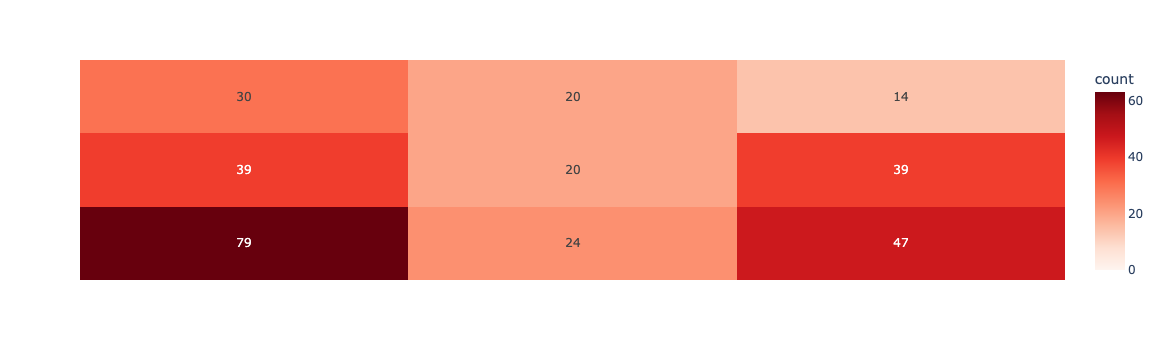

In [105]:
fig = px.density_heatmap(df, x="ZoneHAlt", y="ZoneV", text_auto=True, color_continuous_scale='reds', range_color=[0,63])
fig.update_yaxes(visible=False)
fig.update_xaxes(visible=False)
fig.show()

Whether they shoot, left, right or down the middle, there is a clear preference to shoot in the lower third of the goal, with much fewer shots in the top third.



## 3. Do takers miss target more shooting left or right?

In [110]:
df.groupby(['ZoneHAlt']).Goal.mean()

ZoneHAlt
-1.0    0.675676
 0.0    0.640625
 1.0    0.740000
Name: Goal, dtype: float64

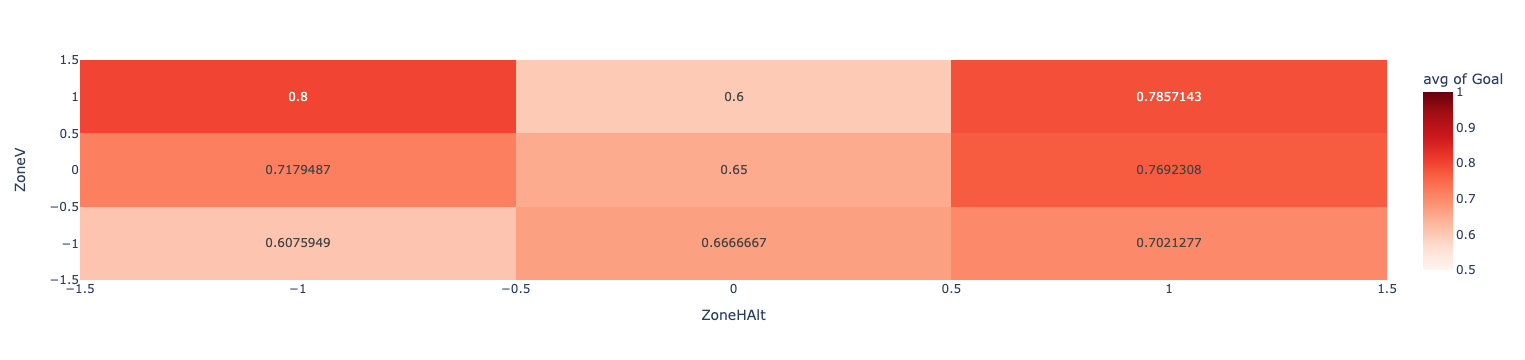

In [106]:
fig = px.density_heatmap(df, x="ZoneHAlt", y="ZoneV", z="Goal", histfunc='avg', text_auto=True, color_continuous_scale='reds', range_color=[0.5,1])
fig.show()

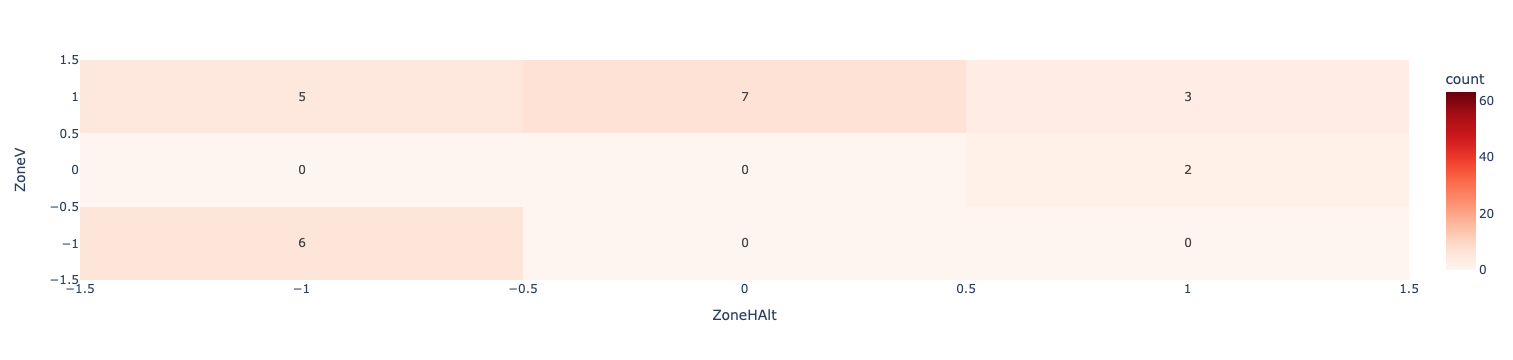

In [134]:
fig = px.density_heatmap(df[df.OnTarget == 0], x="ZoneHAlt", y="ZoneV", text_auto=True, color_continuous_scale='reds', range_color=[0,63])
fig.show()

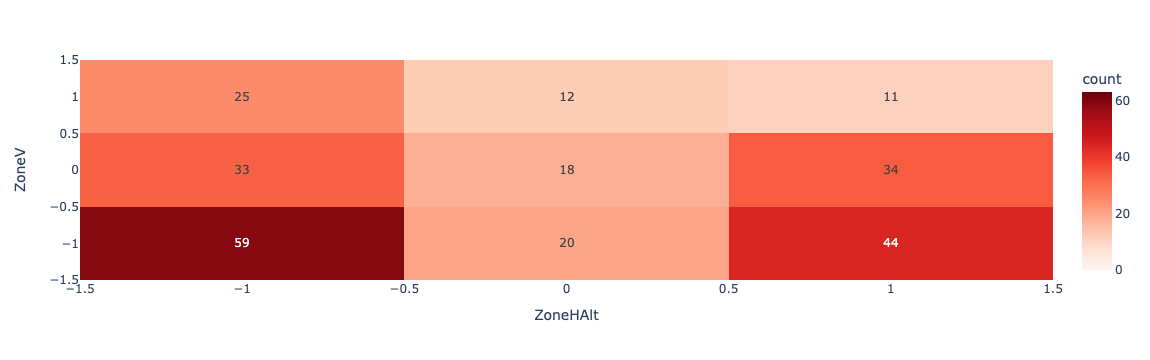

In [133]:
fig = px.density_heatmap(df[df.OnTarget == 1], x="ZoneHAlt", y="ZoneV", text_auto=True, color_continuous_scale='reds', range_color=[0,63])
fig.show()

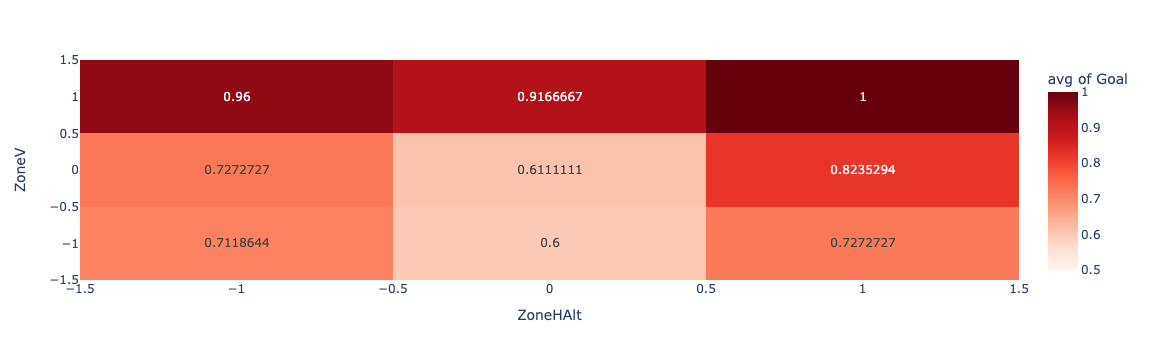

In [131]:
fig = px.density_heatmap(df[df.OnTarget == 1], x="ZoneHAlt", y="ZoneV", z="Goal", histfunc='avg', text_auto=True, color_continuous_scale='reds', range_color=[0.5,1])
fig.show()

In [113]:
df.groupby(['KeeperAlt']).Penalty_Number.count()/ df.Penalty_Number.count()

KeeperAlt
-1.0    0.427632
 0.0    0.118421
 1.0    0.365132
Name: Penalty_Number, dtype: float64

In [115]:
df.groupby(['ZoneHAlt','KeeperAlt']).Penalty_Number.count()/ df.groupby(['ZoneHAlt']).Penalty_Number.count()

ZoneHAlt  KeeperAlt
-1.0      -1.0         0.593750
           0.0         0.085938
           1.0         0.320312
 0.0      -1.0         0.368421
           0.0         0.140351
           1.0         0.491228
 1.0      -1.0         0.351064
           0.0         0.180851
           1.0         0.446809
Name: Penalty_Number, dtype: float64

In [117]:
df.groupby(['ZoneHAlt','Goal']).Penalty_Number.count()/ df.groupby(['ZoneHAlt']).Penalty_Number.count()

ZoneHAlt  Goal
-1.0      0.0     0.296875
          1.0     0.703125
 0.0      0.0     0.403509
          1.0     0.596491
 1.0      0.0     0.244681
          1.0     0.755319
Name: Penalty_Number, dtype: float64

In [119]:
df.groupby(['Zone','Goal']).Penalty_Number.count()/ df.groupby(['Zone']).Penalty_Number.count()

Zone  Goal
1.0   0.0     0.250000
      1.0     0.750000
2.0   0.0     0.421053
      1.0     0.578947
3.0   0.0     0.125000
      1.0     0.875000
4.0   0.0     0.250000
      1.0     0.750000
5.0   0.0     0.388889
      1.0     0.611111
6.0   0.0     0.242424
      1.0     0.757576
7.0   0.0     0.365079
      1.0     0.634921
8.0   0.0     0.400000
      1.0     0.600000
9.0   0.0     0.260870
      1.0     0.739130
Name: Penalty_Number, dtype: float64

In [118]:
df.groupby(['ZoneHAlt','OnTarget']).Penalty_Number.count()/ df.groupby(['ZoneHAlt']).Penalty_Number.count()

ZoneHAlt  OnTarget
-1.0      0.0         0.085938
          1.0         0.914062
 0.0      0.0         0.122807
          1.0         0.877193
 1.0      0.0         0.053191
          1.0         0.946809
Name: Penalty_Number, dtype: float64

In [ ]:
df.groupby(['ZoneHAlt','OnTarget']).Penalty_Number.count()/ df.groupby(['ZoneHAlt']).Penalty_Number.count()